In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import tqdm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping, LearningRateScheduler
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from datetime import *
import seaborn as sns
sns.despine()

import warnings
warnings.filterwarnings('ignore')

import autoreload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Const

In [3]:
STAMP = datetime.now().strftime('%Y-%m-%d_%H:%M')
batch_size = 100
is_normed_y = True
complex_col = ['raits', 'specialities', 'added_on']
sel_col = ['league', 'colour', 'rareness', 'player_id', 'revision']

# Methods

In [4]:
def plot_prediction(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]
    for y_true_i, y_pred_i in zip(y_true, y_pred):
        plt.figure()
        plt.plot(y_true_i)
        plt.plot(y_pred_i)
        plt.title('model prediction')
        plt.ylabel('date')
        plt.xlabel('prediction')
        plt.legend(['true', 'prediction'], loc='best')
        plt.show()

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def plot_loss_acc_history(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Data

In [5]:
df = pd.read_csv("../data/player_price.csv")
filledna_df = pd.DataFrame()
#fillna
for id in tqdm.tqdm(df["player_id"].unique()):
    price_id = df[df["player_id"] == id].copy()
    price_id['xbox_price'].replace(0, np.nan, inplace=True)
    price_id['xbox_price'].bfill(inplace=True)
    price_id['xbox_price'].ffill(inplace=True)
    filledna_df = pd.concat([filledna_df, price_id])
df = filledna_df
#log
if is_normed_y:
    df["xbox_price"] = np.log(df["xbox_price"])

df_stats = pd.read_csv('../data/player_stats.csv')
for col in df_stats.select_dtypes(include=['object']).columns:
    factorized_array = pd.factorize(df_stats[col])
    df_stats[col]=factorized_array[0]
#     print(col, factorized_array[1])

sample_subm = pd.read_csv("../data/kaggle_sample_submission.csv")
sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

df = df[df["player_id"].isin(sample_subm["player_id"].unique())]
df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.drop(["timestamp", "ps_price", "player_name"], axis=1, inplace=True)
df = df.rename(columns = {'xbox_price': 'price'})
pred_size = len(sample_subm['Date'].unique()) #7
hist_window = 14
k_folds = 3
# hist_windows = [7, 14, 28, 56]
print(df.columns)

100%|██████████| 4601/4601 [01:11<00:00, 64.46it/s] 


FileNotFoundError: File b'../data/kaggle_sample_submission.csv' does not exist

# Rolling data

In [5]:
dataForModel = df[(df["Date"] > df["Date"].max() - timedelta(days=pred_size*2 + hist_window))]
# dataForModel["Date"] = dataForModel["Date"].astype(str)
# print(dataForModel.head())
dfModel = pd.DataFrame()
dfVal = pd.DataFrame()
for pid in tqdm.tqdm(sorted(dataForModel.player_id.unique())):
    s=series_to_supervised(dataForModel[dataForModel.player_id == pid]['price'].tolist(), n_in=hist_window, n_out=7, dropnan=True)
    stat = df_stats[df_stats['player_id']==pid][sel_col]

    stat_model= pd.DataFrame()
    for i in range(s.shape[0]-1):
        stat_model = pd.concat([stat_model, stat])
    stat_model.index = s.iloc[:-1, :].index
    dfModel = pd.concat([dfModel, stat_model.join(s.iloc[:-1, :])])
    stat.index = s.iloc[-1:, :].index
    dfVal = pd.concat([dfVal,  stat.join(s.iloc[-1:, :])])
print("Data is ready!!!")
print(dfModel.shape)
print(dfVal.shape)
# dfModel=dfVal

100%|██████████| 1253/1253 [00:22<00:00, 21.73it/s]

Data is ready!!!
(8771, 26)
(1253, 26)


In [6]:
dfModel.columns

Index(['league', 'colour', 'rareness', 'player_id', 'revision', 'var1(t-14)',
       'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)', 'var1(t-9)',
       'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)',
       'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)', 'var1(t+1)',
       'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)', 'var1(t+6)'],
      dtype='object')

# Single 

In [33]:
dataForModel = df[(df["Date"] > df["Date"].max() - timedelta(days=pred_size*2 + hist_window))]
dataForModel["Date"] = dataForModel["Date"].astype(str)

dataForModel = pd.pivot_table(dataForModel, values="price", 
                              index='player_id', columns='Date',
                              aggfunc=np.sum)
print(dataForModel.shape)
dfModel = dataForModel.iloc[:, :-pred_size]
dfVal = dataForModel.iloc[:, pred_size:]
dfModel = df_stats[sel_col].merge(dfModel, right_index=True, left_on='player_id')
dfModel.drop(['player_id'], axis=1, inplace=True)
dfVal = df_stats[sel_col].merge(dfVal, right_index=True, left_on='player_id')
dfVal.drop(['player_id'], axis=1, inplace=True)

print(dfVal.shape)
print(dfModel.shape)

(1253, 28)
(1253, 25)
(1253, 25)


In [72]:
print(dfModel.shape)
stat_size = len(sel_col)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X = dfModel.iloc[:, :stat_size+hist_window]
X_val = dfVal.iloc[:, :stat_size+hist_window]

y = dfModel.iloc[:, -pred_size:]


X = scaler.fit_transform(X)
y = scaler_y.fit_transform(y)



X_val = dfVal.iloc[:, :stat_size+hist_window]
X_val = scaler.transform(X_val)

y_val = dfVal.iloc[:, -pred_size:]
y_val = scaler_y.transform(y_val)

X_test = pd.concat([dfVal.iloc[:, :stat_size], dfVal.iloc[:, -hist_window:]], axis=1)
X_test = scaler.transform(X_test)

X_val_np = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
y_val_np = y_val

(8771, 26)


In [41]:
print('X_test', X_test.shape)
print('X', X.shape)

X_test (1253, 19)
X (1253, 19)


In [133]:
input_shape = X.shape

In [136]:
def build_lstm_model(num_output = 7, num_lstm = 150, optimizer='adam', dropout_rate=0.0, 
                     num_add_lstm_layers = 1,
                     num_add_dence_layers = 1,
                    num_dence_units = 100):
    model = Sequential()

    model.add(LSTM(num_lstm, input_shape=(1, input_shape[1]), return_sequences=num_add_lstm_layers>0))
    model.add(Dropout(dropout_rate))
    
    for i in range(num_add_lstm_layers) :
        model.add(LSTM(num_lstm,return_sequences=(i < num_add_lstm_layers)))
        model.add(Dropout(dropout_rate))
   

    for i in range(num_add_dence_layers) :    
        model.add(Dense(num_dence_units))
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))
    
    
    model.add(Dense(output_dim=num_output))
    model.add(Activation("linear"))

    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

In [139]:

epochs = 40
optimizers= ['adam', 'rmsprop', SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)]
num_lstm_units = [25, 75 , 150 ,225]
dropout_rates = [0.0, 0.25, 0.5, 0.75]
epochs = [40, 70, 120]
num_add_lstm_units = [1,2]
num_add_dence_layers = [1,2]


# early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=2)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
lrScheduler  = LearningRateScheduler(lambda x: 0.001 if x<int(epochs*0.8) else 0.0001)

X_np = X.reshape(X.shape[0], 1, X.shape[1])
X_test_np = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

y_np=y
# y_np = y.as_matrix()
# validation_data=(X_val_np, y_val_np)
# validation_split=0.2
# hist = model.fit(X_np, y_np, validation_split=0.2, epochs=epochs, batch_size=30, callbacks=[ note_callback, model_checkpoint, lrScheduler ])


model = KerasRegressor(build_fn=build_full_model,validation_data=(X_val_np, y_val_np), epochs=epochs, batch_size=40, callbacks=[ model_checkpoint, note_callback, lrScheduler])

param_grid = dict( num_add_lstm_layers = num_add_lstm_units, optimizer=optimizers, dropout_rate=dropout_rates)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_np, y_np)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# hist = model.fit(X_np, y_np,  validation_data=(X_val_np, y_val_np), epochs=epochs, batch_size=40, callbacks=[ model_checkpoint, note_callback, lrScheduler])
# hist = model.fit(X_val_np, y_val_np, epochs=epochs, batch_size=30,  callbacks=[ note_callback, model_checkpoint, lrScheduler ])

# model.load_weights(bst_model_path)
# plot_loss_acc_history(hist)
# bst_val_score = min(hist.history['val_loss'])
# print('val_mean_squared_error = ', bst_val_score)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
valScore = math.sqrt(mean_squared_error(np.exp(scaler_y.inverse_transform(y_val_np)), np.exp(scaler_y.inverse_transform(model.predict(X_val_np)))))
print(valScore)

55792.033212683265


In [73]:
predict = model.predict(X_np)

predict_scaled = scaler_y.inverse_transform(predict)

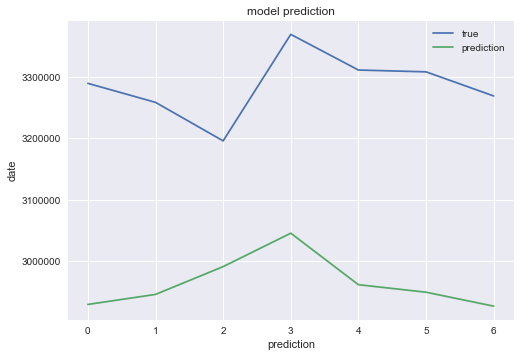

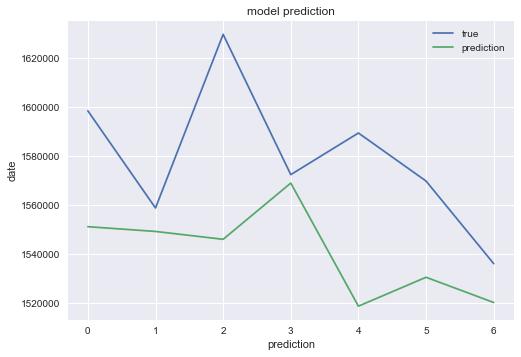

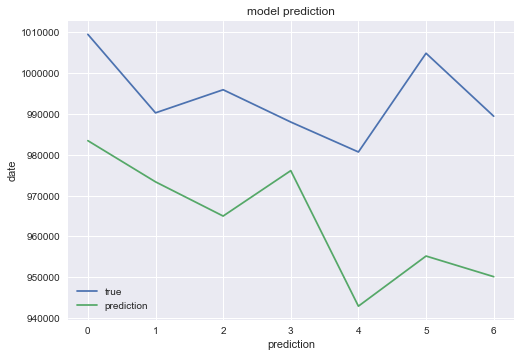

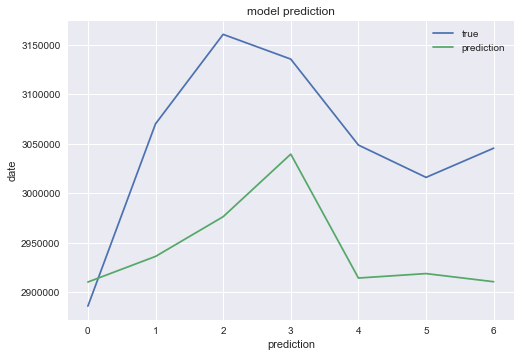

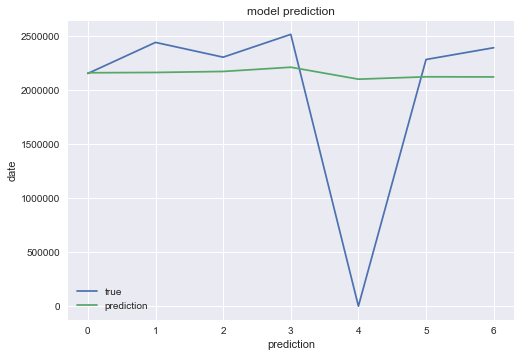

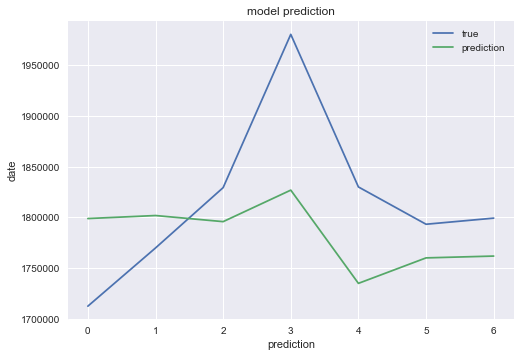

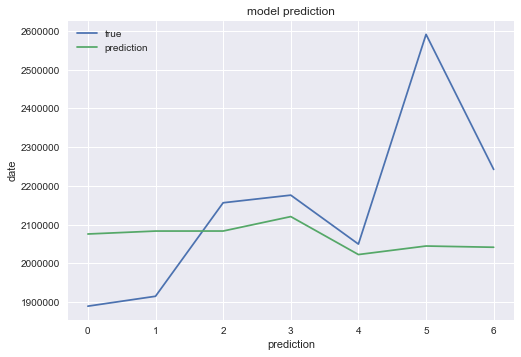

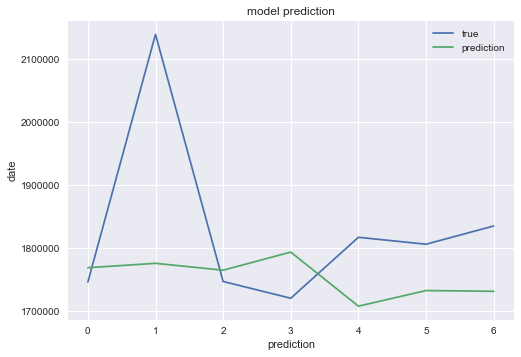

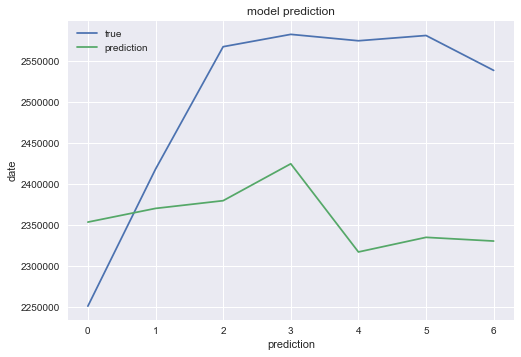

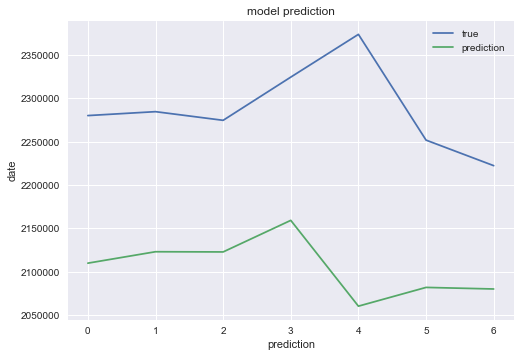

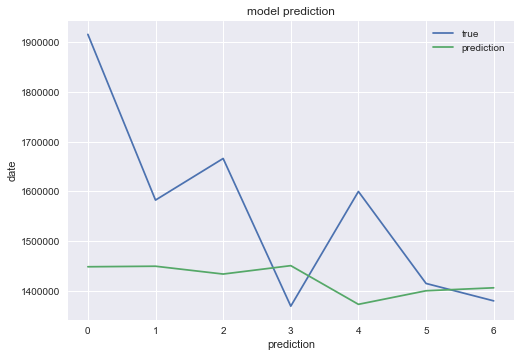

In [151]:
y_true = scaler_y.inverse_transform(y_np)

plot_prediction(y_true[y_true[:,0] > 1000000], predict_scaled[y_true[:,0] > 1000000])

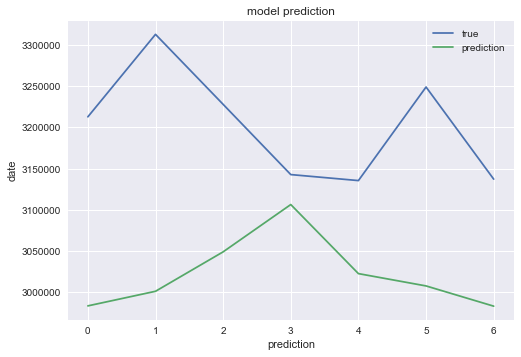

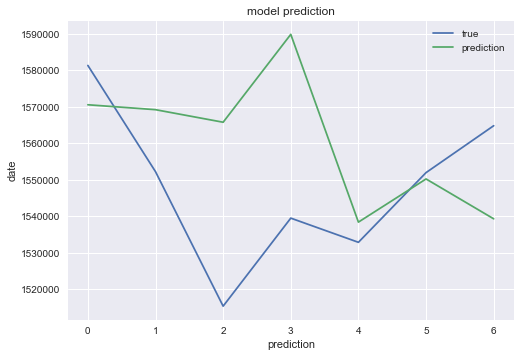

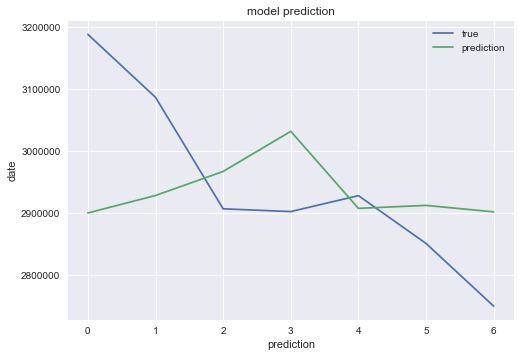

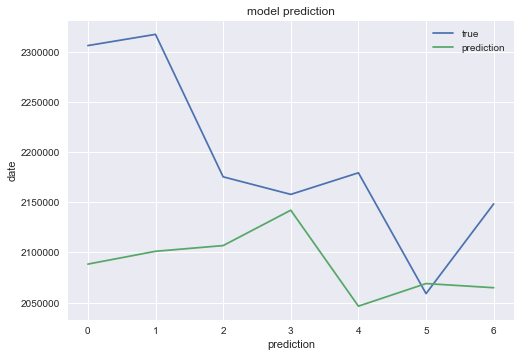

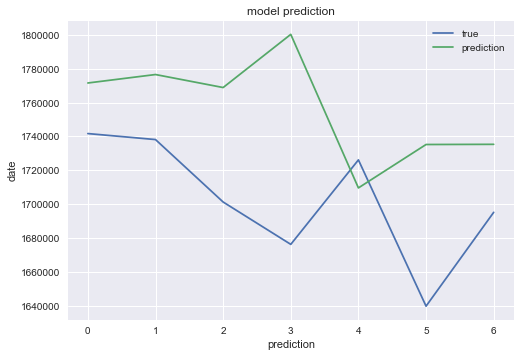

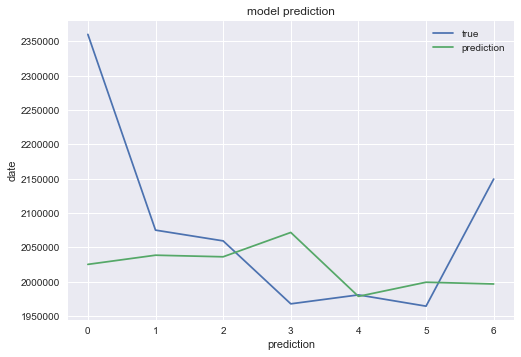

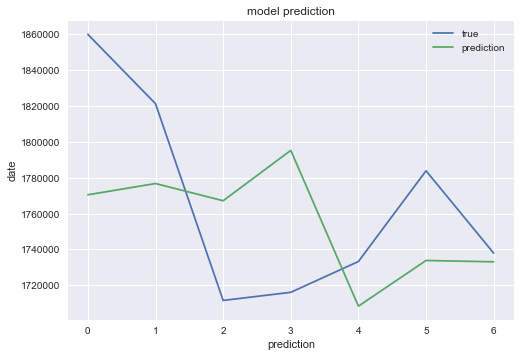

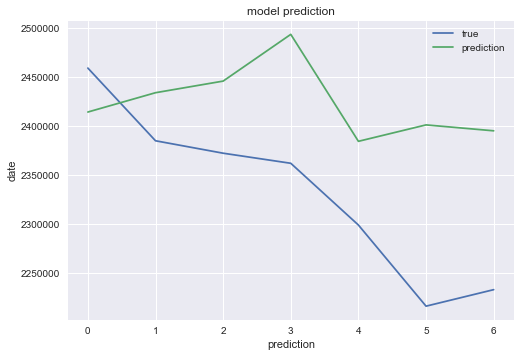

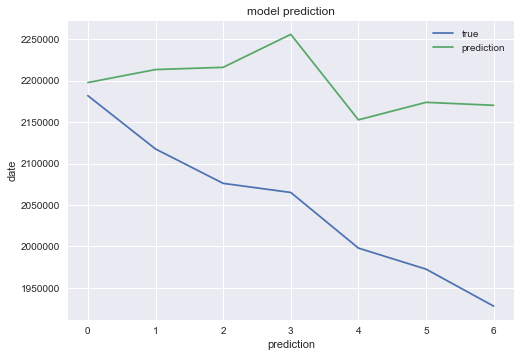

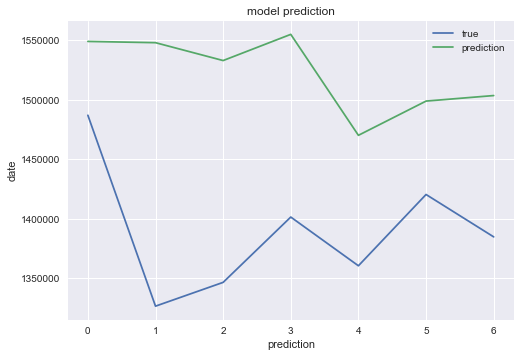

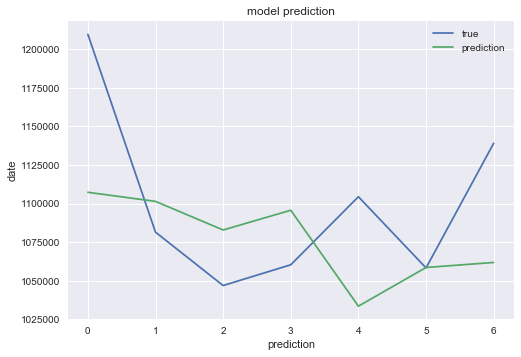

In [144]:
y_true = scaler_y.inverse_transform(y_val_np)
predict = model.predict(X_val_np)

predict_scaled = scaler_y.inverse_transform(predict)
plot_prediction(y_true[y_true[:,0] > 1000000], predict_scaled[y_true[:,0] > 1000000])

In [83]:
print(sample_subm.shape)
predict = model.predict(X_test_np)

predict_scaled = scaler_y.inverse_transform(predict)
predict_np = predict_scaled.reshape(predict_scaled.shape[0]*predict_scaled.shape[1],)
print(predict_np.shape)
if is_normed_y:
    predict_np = np.exp(predict_np)
sample_subm["price"] = predict_np

sample_subm[["id", "price"]].to_csv("neural_subm.csv", index=False)

(8771, 4)
(8771,)


In [85]:
sample_subm.head(10)

,id,price,player_id,Date
0,1_2017-06-23,3.027929e+06,1,2017-06-23
1,1_2017-06-24,2.940370e+06,1,2017-06-24
2,1_2017-06-25,2.822254e+06,1,2017-06-25
3,1_2017-06-26,2.830470e+06,1,2017-06-26
4,1_2017-06-27,2.908916e+06,1,2017-06-27
5,1_2017-06-28,2.915187e+06,1,2017-06-28
6,1_2017-06-29,2.902845e+06,1,2017-06-29
7,2_2017-06-23,7.387962e+05,2,2017-06-23
8,2_2017-06-24,7.238159e+05,2,2017-06-24
9,2_2017-06-25,7.018429e+05,2,2017-06-25
